# Simulation example with the BRAID model

In this notebook, we present an example of a simulation of the BRAID model on a single stimulus. Given this stimulus, and given an number of iterations to run, the model simulates letter perception, word recognition, lexical decision and word reading, simultaneously. To do this, probability distributions evolve as visual processing is performed, to update knowledge about the identity of letters, about the identity of the presented word (under the assumption that it is a known word), about lexical membership, and finally, about phonemes.

## 1. BRAID initialization, simulation configuration

First, we add the path to the project folder to correctly load the necessary files. Second, we load them using the import command in Python interpreter.

In [1]:
import sys, os
sys.path.append("../")
import numpy as np
import pandas as pd

from braidpy.simu import simu       # simulation context
import braidpy.braid_plot as brplt  # plotting library

The class `simu` allows declaring a "simulation context", which, among other things, allows configuring the simulation (which lexicon, which model parameters, which confusion matrix for letters, which stimuli, etc.). It also creates an instance object of the model (class `braid`). This object gathers all parameters and methods necessary to perform the simulation. The following commands initialize the simulation, for the moment with temporary values for some parameters, that we will change afterwards.

In [2]:
sim = simu( max_iter = 1000,  
            stim = "stimulus",                  #temp stimulus just to initialize the simu context
            langue = "en",
            lexicon_name = "",  
            conf_mat_name = "",  
            ortho_char_name = "",
            phono_char_name = "",
            enable_phono = True,
            store_phono = True,  
            store_ortho = True,  
            model = None,  
            use_pkl = False,  
            save_pkl = False,
            build_prototype = False
            )
model = sim.model

We now define the stimulus, some parameters of interest, and the probability distributions we want to store in the simulation context.
- the stimulus is the input letter string "house".
- visuo-attentional parameters set the gaze position (in the middle of the input letter string), the position of the focus of attention (in the middle of the input letter string, too), the dispersion of visual attention (1.75, the default value), and the total amount of available attentional resource (1, the default value).
- we configure the model to include a top-down, lexical influence on letter perception.
- finally, we set the distributions to be memorized along the simulation, for visualization purposes.

In [3]:
# stimulus definition
stimulus = "house"
model.stim = stimulus

# visuo-attentional parameters
model.gazePosition = (len(stimulus)+1)/2 - 1        
model.meanA = (len(stimulus)+1)/2 - 1           # VA focus
model.sdA = 1.75                                # VA std dev
model.Qa = 1                                    # VA total amount of attention

# is there lexical influence on letter perception?
model.top_down_influence = True                 

# distrbutions to save
sim.store={"percept":True, "word":True, "ld":True, "TDI":True}

## 2. Running the simulation

Once the simulation is configured, running it is done with:

In [4]:
## Running simulation
sim.run_simu_normal()

SIMU:root:Stimulus: house
SIMU:root:simulation duration: 1000
SIMU:root:ld ortho: 0.9936
SIMU:root:percept ortho: house [0.868, 0.888, 0.898, 0.905, 0.857]
SIMU:root:word ortho:  house, /haUs/, wmax = 0.9991 
SIMU:root:ld phono: 0.5
SIMU:root:percept phono: haUs [0.75, 0.874, 0.881, 0.783, 0.398, 0.051, 0.026, 0.023, 0.023]
SIMU:root:word phono:  house, /haUs/, wmax = 0.9991 
SIMU:root:generated phonological form: /haUs#####/
SIMU:root:fixation position(s): [2.0]
SIMU:root:fixation VA dispersion(s): [1.75]


In [5]:
sim.res["ortho"]["percept"]["house"].shape

(5, 27, 1001)

## 3. Visualizing distributions over perceived letters

Here, we visualize the evolution of probability distributions over letters at each position of the input letter string. The letter string "house" is of length 5, so we obtain 5 plots. Each plot shows, at each iteration, the discrete probability distribution over all letters (each plot actually has 27 curves, which sum to 1; however, most are almost superposed).

Initially, all plots start from uniform distributions over letters (1/27 = 0.037 for each possible letter). As simulated time passes (iterations increase), sensory evidence about the identity of letters in the input string are accumulated, making these probability distributions evolve. These evolutions depend on the quantity of attention allocated to each position, and of possible interference with adjacent letters. 

In this simple case, all letters are correctly identified: at the end, all probability distributions feature high values on the correct letter at each position ("h" at position 0, "o" at position 1, etc.) 

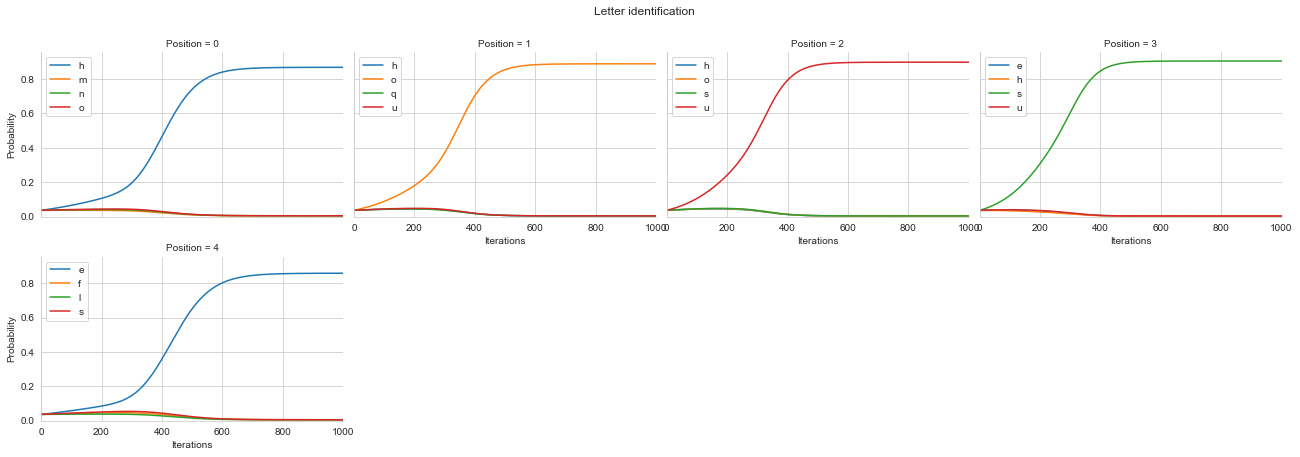

In [6]:
brplt.plot_letter_distribution_evo(model, sim.res["ortho"]["percept"][stimulus], 
                                stimulus = stimulus, item_to_show = 4, pos2plot =-1);

This command only shows the plot for a given position (`pos2plot=1` here, "o" gets high probability).

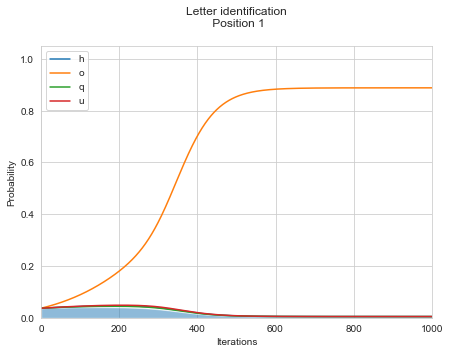

In [7]:
brplt.plot_letter_distribution_evo(model, sim.res["ortho"]["percept"][stimulus],
                                   stimulus = stimulus, item_to_show = 4, pos2plot = 1, fig_sz = (7,5));

## 4. Visualizing the distribution over lexical membership

We now visualize the evolution over time of the distribution over lexical membership. This portion of the model assesses whether the input letter string corresponds to a known word or not (i.e., is it a word in the lexicon or not?). The representation space here is Boolean: the word either is in the lexicon (`yes` answer) or not (`no` answer). In its default configuration, the model starts with a 50/50 prior probability (unrealistic in "real life", but this is often the case in research experiments, in which half the presented stimuli are words, and half are non-words of some sort). The computed probability distributions can thus be used to simulate the lexical decision task (e.g., with a decision threshold).

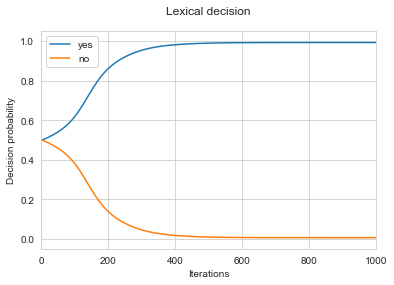

In [8]:
brplt.plot_lexical_decision_evo(model, sim.res["ortho"]["ld"][stimulus], stimulus)

## 5. Visualizing the distribution over words

We now visualize the evolution over time of the distribution over words. Here, each curve is the evolution of probability for a single word hypothesis. Depending on the chosen lexicon, there are hundreds or thousands of points in the word space: the plot only shows curves for words which get, at some point of the simulation, a high enough probability (in its default configuration, BRAID only considers words of the same length as the input letter string, for the sake of computation time).

Contrary to distributions over letters, this distribution does not start, at iteration 0, with a uniform distribution. Instead, the prior distribution is related to the frequency of words (as provided by the lexicon used). 

As sensory evidence about the identity of letters in the input letter string is accumulated, the probabilities of words evolve. Here, the correct word "house" gets very high probability. We note that competitors are, of course, either very close neighbors (e.g., "hours") or close neighbors with high frequency (e.g., "would", "which").

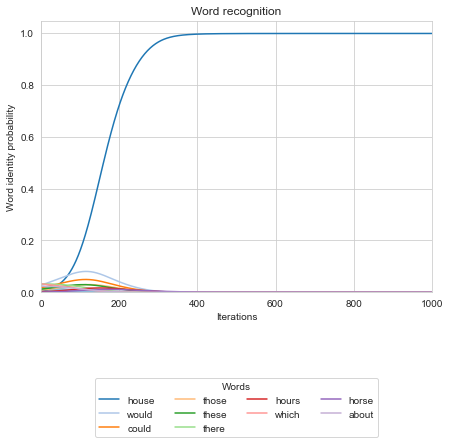

In [9]:
brplt.plot_word_distribution_evo(model,sim.res["ortho"]["word"][stimulus], item_to_show = 10, stimulus = stimulus, fig_sz = (7,5));

## 6. Visualizing distributions over phonemes

Here, we visualize the evolution over time of probability distributions over phonemes (the model simulates reading aloud). The length of the phonological output is not necessarily identical to the length of the orthographic input: therefore, we show here "more plots than necessary", and the phonemic space contains a special value (`#`, red curves) indicating the "end-of-sequence" phoneme. Other than that, the probability distributions over phonemes are similar to the ones over letters: they start at the uniform distribution, then evolve as sensory evidence is accumulated (from the word distribution). This simulation provides the correct phonological output (/haUs/; plot legends should display the correct phonemic notation).

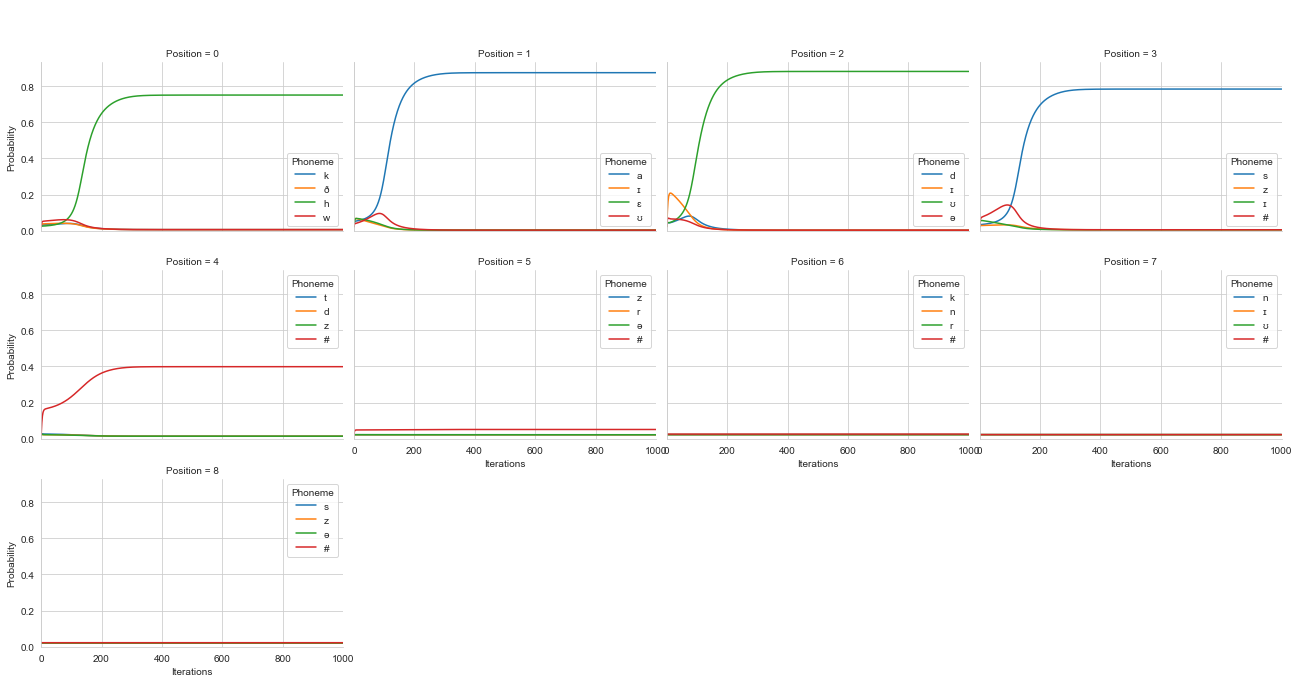

In [10]:
brplt.plot_phoneme_distribution_evo(model, sim.res["phono"]["percept"][stimulus], stimulus=stimulus, item_to_show = 4, col_wrap = 4, pos2plot = -1);

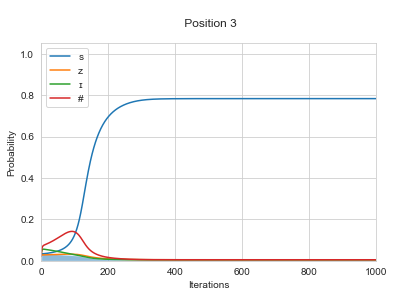

In [11]:
brplt.plot_phoneme_distribution_evo(model, sim.res["phono"]["percept"][stimulus], stimulus=stimulus, item_to_show = 4, col_wrap = 4, pos2plot = 3);

## 7. Modifying the simulation and running it again

In this section, we "play around" with the model. We will:
1. move the visuo-attentional parameters and gaze position (i.e., move the eye and visual attention around on the stimulus);
2. change the stimulus to another word ("mouse"), which is a neighbor of word "house", but much less frequent;
3. move again visuo-attentional parameters, to focus either on left positions (which help discriminating between "house" and "mouse"), or on right positions (which do not help discriminating).
4. change the stimulus to non-words, that either are close to existing words ("hoyse", close to "house") or not at all ("gekaz", "gcktz").

At this stage, we encourage you to try and predict the resulting plots before looking at them. 

### 7.1. Moving visuo-attentional parameters and gaze position

First, let us move the visuo-attentional parameters and gaze position to "focus on the left portion of the word", and see how it affects letter recognition and word recognition.

In [12]:
model.gazePosition = 0      
model.meanA = 0

sim.run_simu_normal()

SIMU:root:Stimulus: house
SIMU:root:simulation duration: 1000
SIMU:root:ld ortho: 0.992
SIMU:root:percept ortho: house [0.931, 0.904, 0.864, 0.832, 0.676]
SIMU:root:word ortho:  house, /haUs/, wmax = 0.9989 
SIMU:root:ld phono: 0.5
SIMU:root:percept phono: haUs [0.931, 0.907, 0.767, 0.252, 0.037, 0.024, 0.023, 0.023, 0.023]
SIMU:root:word phono:  house, /haUs/, wmax = 0.9989 
SIMU:root:generated phonological form: /haUs#####/
SIMU:root:fixation position(s): [0]
SIMU:root:fixation VA dispersion(s): [1.75]


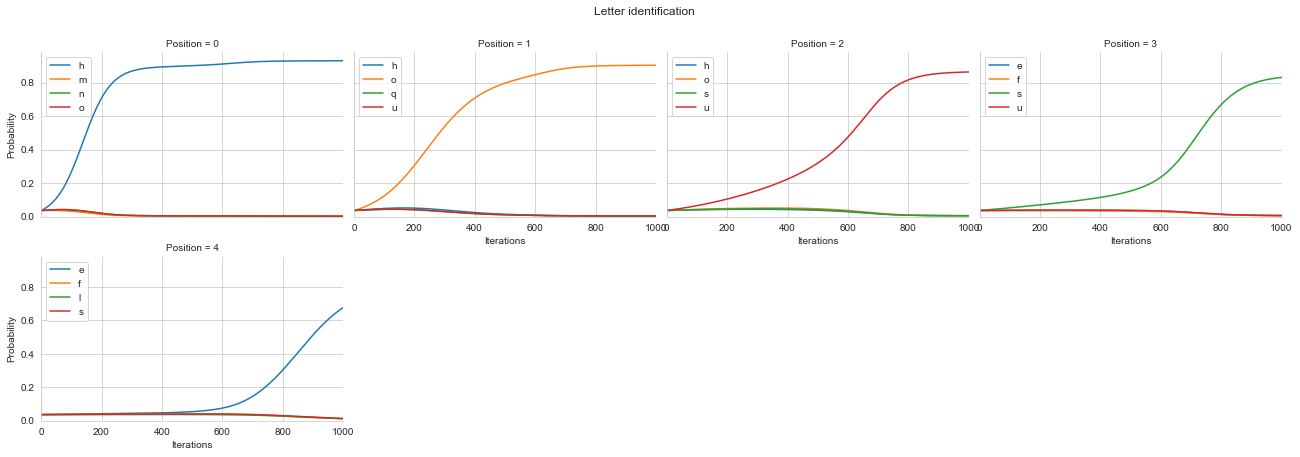

In [13]:
brplt.plot_letter_distribution_evo(model, sim.res["ortho"]["percept"][stimulus], 
                                stimulus = stimulus, item_to_show = 4, pos2plot =-1);

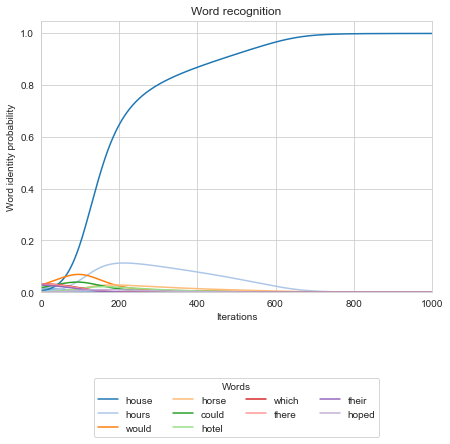

In [14]:
brplt.plot_word_distribution_evo(model,sim.res["ortho"]["word"][stimulus], item_to_show = 10, stimulus = stimulus, fig_sz = (7,5));

Since visual-attention and gaze are on the left-most letter, letter recognition is affected: letters under the focus of attention and gaze are recognized faster than letters to the right of the stimulus. This affects the dynamics of letter and word recognition, but not the "final answer" (assuming a simple decision process based on reaching a fixed probability threshold).

*Suggestion: Try moving attention to position 4 and running the simulation again!*

### 7.2. Changing the stimulus

We now replace the input letter string with "mouse", and re-set visuo-attentional parameters and gaze position to the middle of the stimulus.

In [15]:
# stimulus definition
stimulus = "mouse"
model.stim = stimulus

# visuo-attentional parameters
model.gazePosition = (len(stimulus)+1)/2 - 1        
model.meanA = (len(stimulus)+1)/2 - 1           # VA focus
model.sdA = 1.75                                # VA std dev
model.Qa = 1                                    # VA total amount of attention

sim.run_simu_normal()

SIMU:root:Stimulus: mouse
SIMU:root:simulation duration: 1000
SIMU:root:ld ortho: 0.9279
SIMU:root:percept ortho: mouse [0.788, 0.804, 0.833, 0.851, 0.593]
SIMU:root:word ortho:  mouse, /maUs/, wmax = 0.9232 
SIMU:root:ld phono: 0.5
SIMU:root:percept phono: maUs [0.726, 0.874, 0.881, 0.783, 0.398, 0.051, 0.026, 0.023, 0.023]
SIMU:root:word phono:  mouse, /maUs/, wmax = 0.9232 
SIMU:root:generated phonological form: /maUs#####/
SIMU:root:fixation position(s): [2.0]
SIMU:root:fixation VA dispersion(s): [1.75]


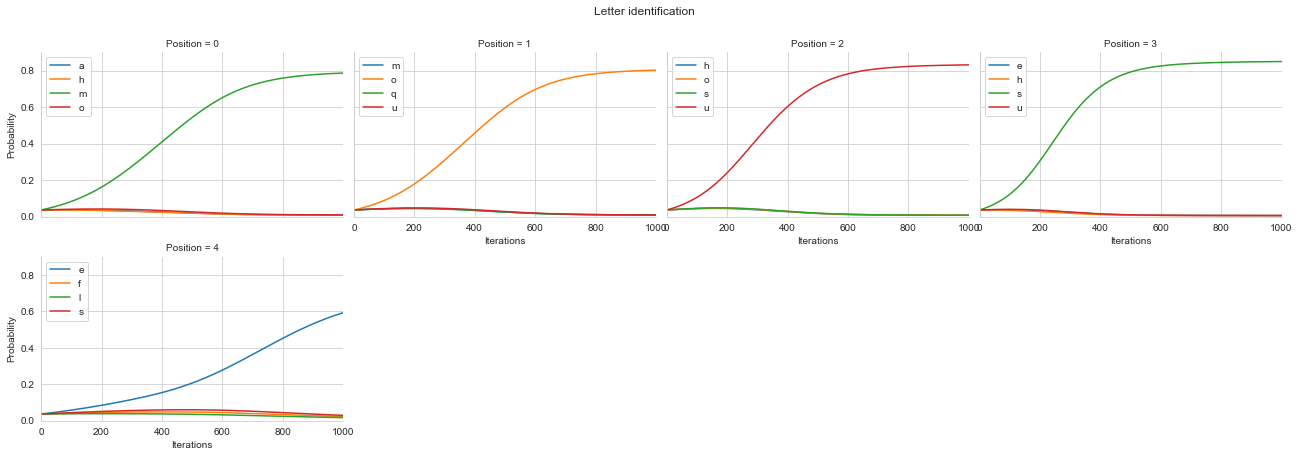

In [16]:
brplt.plot_letter_distribution_evo(model, sim.res["ortho"]["percept"][stimulus], 
                                stimulus = stimulus, item_to_show = 4, pos2plot =-1);

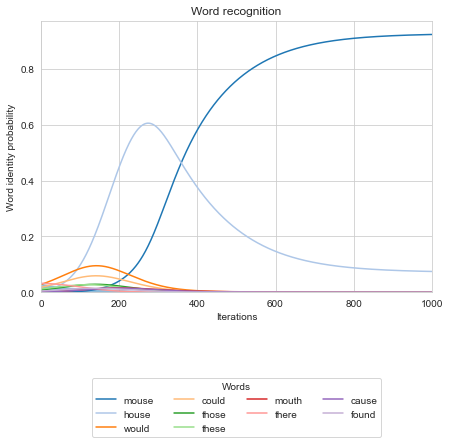

In [17]:
brplt.plot_word_distribution_evo(model,sim.res["ortho"]["word"][stimulus], item_to_show = 10, stimulus = stimulus, fig_sz = (7,5));

Letters are correctly recognized, although somewhat slower than with stimulus "house". The reason lies in the dynamics of word recognition: the probability over words clearly shows a transient competition between the correct word ("mouse") and its more frequent neighbor ("house"). However, sensory accumulation of evidence allows resolving this competition successfully, and the correct word is recognized. 

### 7.3 Moving visuo-attentional parameters and gaze position

We now move the eye around the input letter string "mouse". We first set them to be to the left of the input (positions at 0).

In [18]:
model.gazePosition = 0      
model.meanA = 0

sim.run_simu_normal()

SIMU:root:Stimulus: mouse
SIMU:root:simulation duration: 1000
SIMU:root:ld ortho: 0.5822
SIMU:root:percept ortho: mouse [0.926, 0.82, 0.547, 0.248, 0.051]
SIMU:root:word ortho:  mouse, /maUs/, wmax = 0.7308 
SIMU:root:ld phono: 0.5
SIMU:root:percept phono: maUs [0.924, 0.895, 0.749, 0.154, 0.036, 0.024, 0.023, 0.023, 0.023]
SIMU:root:word phono:  mouse, /maUs/, wmax = 0.7308 
SIMU:root:generated phonological form: /maUs#####/
SIMU:root:fixation position(s): [0]
SIMU:root:fixation VA dispersion(s): [1.75]


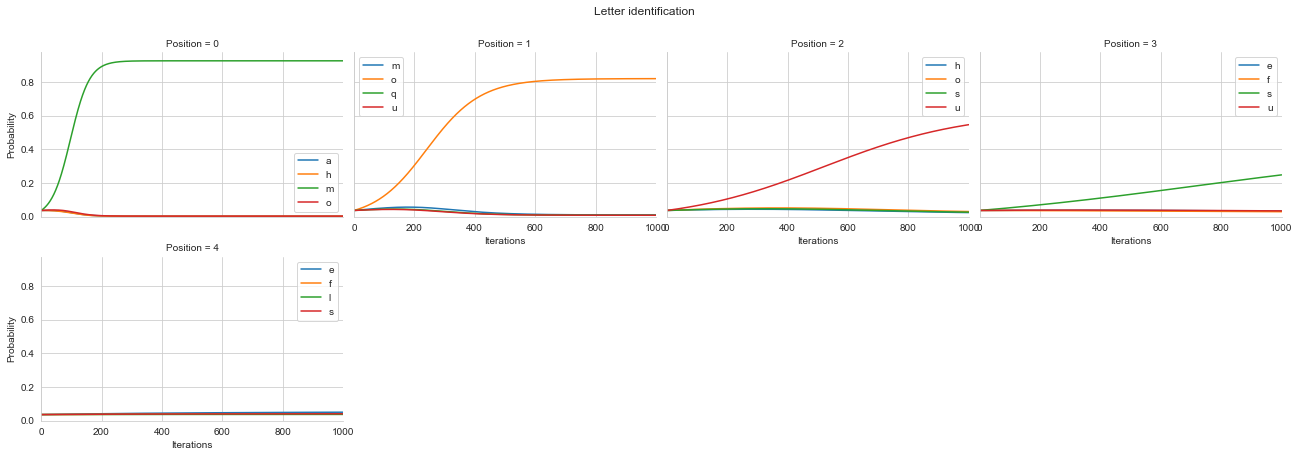

In [19]:
brplt.plot_letter_distribution_evo(model, sim.res["ortho"]["percept"][stimulus], 
                                stimulus = stimulus, item_to_show = 4, pos2plot =-1);

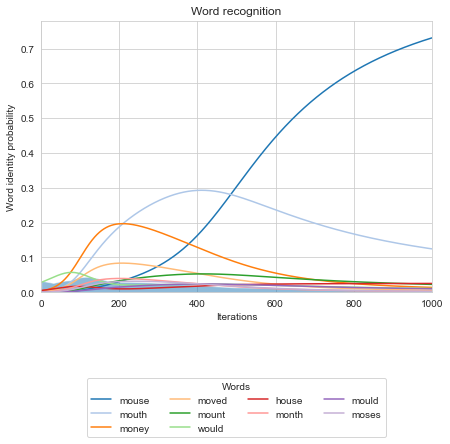

In [20]:
brplt.plot_word_distribution_evo(model,sim.res["ortho"]["word"][stimulus], item_to_show = 10, stimulus = stimulus, fig_sz = (7,5));

We observe, as before, that letter identification is massively affected by visuo-attentional parameters, with letters under the focus of attention and gaze position processed faster.

*Suggestion: Play around with the other two parameters of the visuo-attentional distribution: `model.sdA` defines the spread of attention (smaller values decrease the spread, making processing more efficient locally to the detriment of distant positions), `model.Qa` defines the total amount of visual attention (larger values speed up processing overall).*

In [21]:
model.gazePosition = 4
model.meanA = 4

sim.run_simu_normal()

SIMU:root:Stimulus: mouse
SIMU:root:simulation duration: 1000
SIMU:root:ld ortho: 0.9755
SIMU:root:percept ortho: house [0.126, 0.429, 0.78, 0.911, 0.91]
SIMU:root:word ortho:  house, /haUs/, wmax = 0.9842 
SIMU:root:ld phono: 0.5
SIMU:root:percept phono: haUs [0.088, 0.573, 0.824, 0.877, 0.834, 0.61, 0.107, 0.03, 0.023]
SIMU:root:word phono:  house, /haUs/, wmax = 0.9842 
SIMU:root:generated phonological form: /haUs#####/
SIMU:root:fixation position(s): [4]
SIMU:root:fixation VA dispersion(s): [1.75]


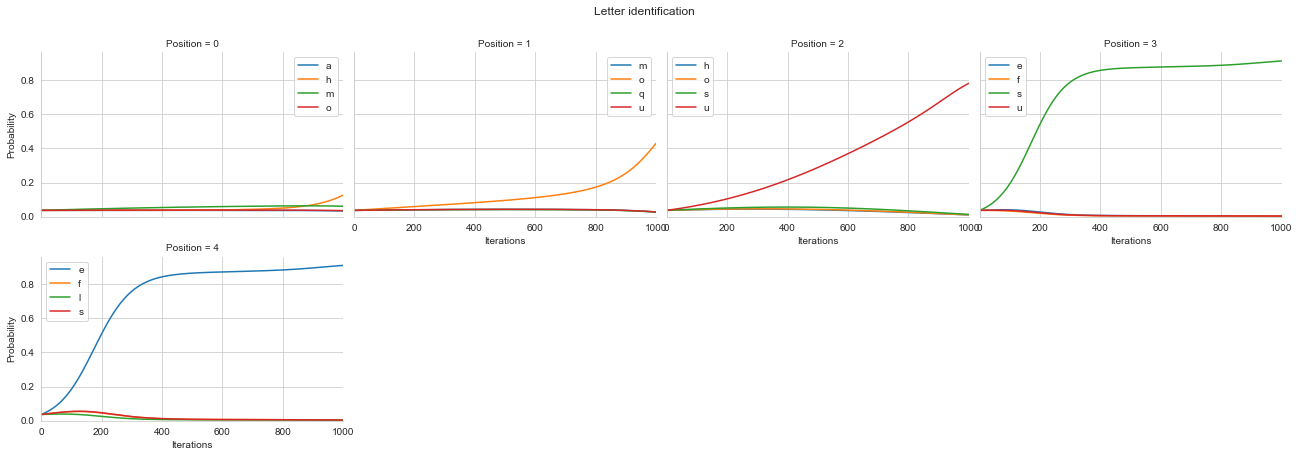

In [22]:
brplt.plot_letter_distribution_evo(model, sim.res["ortho"]["percept"][stimulus], 
                                stimulus = stimulus, item_to_show = 4, pos2plot =-1);

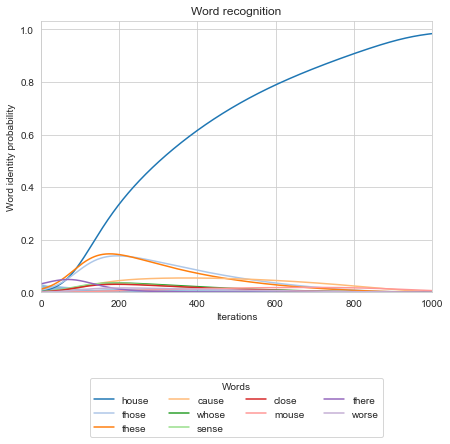

In [23]:
brplt.plot_word_distribution_evo(model,sim.res["ortho"]["word"][stimulus], item_to_show = 10, stimulus = stimulus, fig_sz = (7,5));

With attention and gaze positioned on the last letters of the input letter string "mouse", the model is in a difficult position. Letter recognition is good for the last letters, but the model has basically no idea about the first letter. Therefore, the most likely word (the one that wins competition at the lexical level) is the word "house": it is compatible with perceptual information about letters, and the most frequent candidate. 

Because of the structure of the BRAID model, with hierarchically organized Markov chains, probability distributions at the lexical level influence those at the letter level. Here, we observe, as a consequence, that the probability distribution over letters in the Oth position starts to increase very late (around iterations 950), increasing the probability of letter "h". This is of course not "veridical" with respect to sensory stimulation, but a correct consequence of probabilistic computations in the BRAID model. 

### 7.4. With non-word stimuli

We now reset the model and check its behavior with non-word stimuli. 

In [24]:
# stimulus definition
stimulus = "hoyse"
model.stim = stimulus

# visuo-attentional parameters
model.gazePosition = (len(stimulus)+1)/2 - 1        
model.meanA = (len(stimulus)+1)/2 - 1           # VA focus
model.sdA = 1.75                                # VA std dev
model.Qa = 1                                    # VA total amount of attention

sim.run_simu_normal()

SIMU:root:Stimulus: hoyse
SIMU:root:simulation duration: 1000
SIMU:root:ld ortho: 0.0385
SIMU:root:percept ortho: hoyse [0.56, 0.74, 0.853, 0.821, 0.386]
SIMU:root:word ortho:  house, /haUs/, wmax = 0.8556 
SIMU:root:ld phono: 0.5
SIMU:root:percept phono: haUs [0.745, 0.843, 0.852, 0.74, 0.397, 0.051, 0.026, 0.023, 0.023]
SIMU:root:word phono:  house, /haUs/, wmax = 0.8556 
SIMU:root:generated phonological form: /haUs#####/
SIMU:root:fixation position(s): [2.0]
SIMU:root:fixation VA dispersion(s): [1.75]


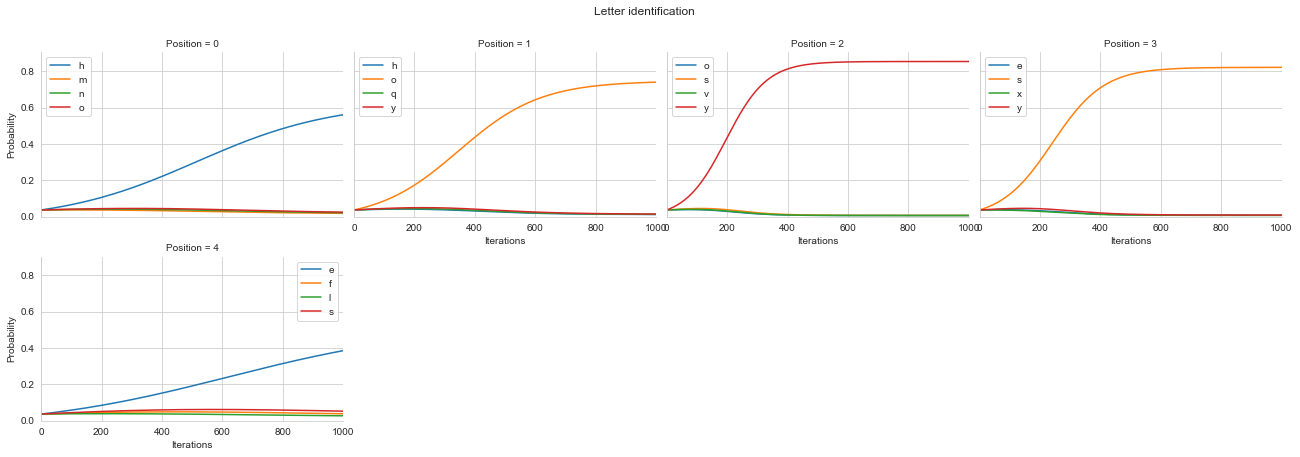

In [25]:
brplt.plot_letter_distribution_evo(model, sim.res["ortho"]["percept"][stimulus], 
                                stimulus = stimulus, item_to_show = 4, pos2plot =-1);

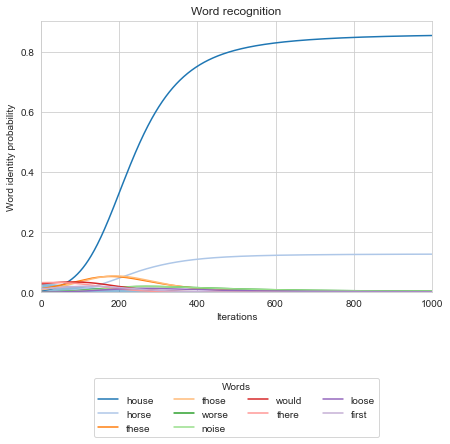

In [26]:
brplt.plot_word_distribution_evo(model,sim.res["ortho"]["word"][stimulus], item_to_show = 10, stimulus = stimulus, fig_sz = (7,5));

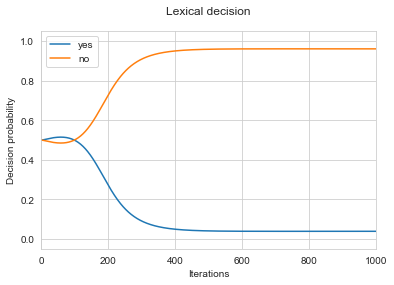

In [27]:
brplt.plot_lexical_decision_evo(model, sim.res["ortho"]["ld"][stimulus], stimulus)

When presented with the input letter string "hoyse", letters are correctly identified, and the most likely word belonging to the lexicon is the word "house". Moreover, the distribution about lexical membership correctly identifies that the input letter string does not belong to the known lexicon (although, with a slight initial "hesitation"). 

We now try with a harder non-word, that shares less letters with words of the lexicon.

In [28]:
# stimulus definition
stimulus = "gekaz"
model.stim = stimulus

# visuo-attentional parameters
model.gazePosition = (len(stimulus)+1)/2 - 1        
model.meanA = (len(stimulus)+1)/2 - 1           # VA focus
model.sdA = 1.75                                # VA std dev
model.Qa = 1                                    # VA total amount of attention

sim.run_simu_normal()

SIMU:root:Stimulus: gekaz
SIMU:root:simulation duration: 1000
SIMU:root:ld ortho: 0.022
SIMU:root:percept ortho: gekaz [0.375, 0.678, 0.823, 0.845, 0.756]
SIMU:root:word ortho:  began, /bIg{n/, wmax = 0.4044 
SIMU:root:ld phono: 0.5
SIMU:root:percept phono: bIg{n [0.368, 0.659, 0.676, 0.422, 0.091, 0.049, 0.026, 0.023, 0.023]
SIMU:root:word phono:  began, /bIg{n/, wmax = 0.4044 
SIMU:root:generated phonological form: /bIg{#####/
SIMU:root:fixation position(s): [2.0]
SIMU:root:fixation VA dispersion(s): [1.75]


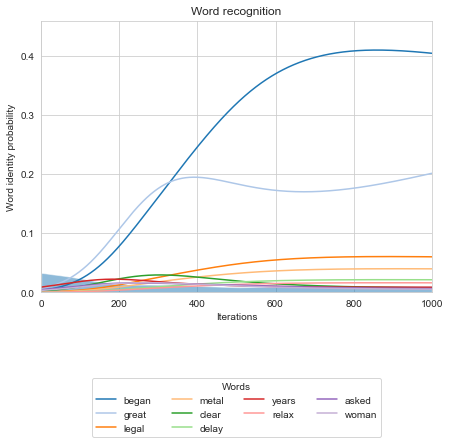

In [29]:
brplt.plot_word_distribution_evo(model,sim.res["ortho"]["word"][stimulus], item_to_show = 10, stimulus = stimulus, fig_sz = (7,5));

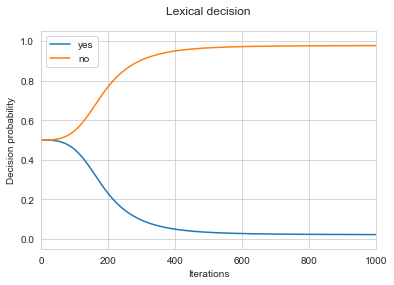

In [30]:
brplt.plot_lexical_decision_evo(model, sim.res["ortho"]["ld"][stimulus], stimulus)

Word recognition is more in trouble: notice that probability values for candidate words do not rise as fast as in previous examples, and do not go much above .4. The probability distribution over lexical membership successfully recognizes the input as a non-word.

The final example is with a stimulus non-word that is a consonant sequence: "gckqz".

In [31]:
# stimulus definition
stimulus = "gckqz"
model.stim = stimulus

# visuo-attentional parameters
model.gazePosition = (len(stimulus)+1)/2 - 1        
model.meanA = (len(stimulus)+1)/2 - 1           # VA focus
model.sdA = 1.75                                # VA std dev
model.Qa = 1                                    # VA total amount of attention

sim.run_simu_normal()

SIMU:root:Stimulus: gckqz
SIMU:root:simulation duration: 1000
SIMU:root:ld ortho: 0.0197
SIMU:root:percept ortho: gckqz [0.413, 0.615, 0.827, 0.654, 0.753]
SIMU:root:word ortho:  asked, /Askt/, wmax = 0.1263 
SIMU:root:ld phono: 0.5
SIMU:root:percept phono: geIk [0.095, 0.286, 0.523, 0.196, 0.096, 0.045, 0.026, 0.023, 0.023]
SIMU:root:word phono:  asked, /Askt/, wmax = 0.1263 
SIMU:root:generated phonological form: /teIk#####/
SIMU:root:fixation position(s): [2.0]
SIMU:root:fixation VA dispersion(s): [1.75]


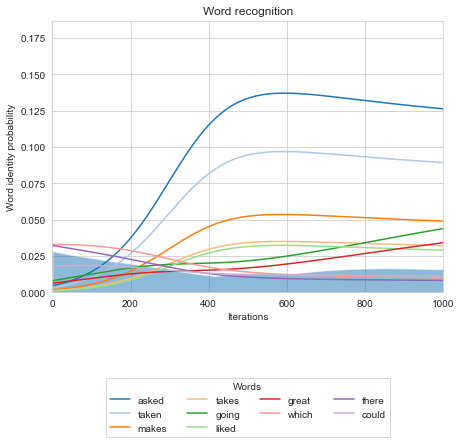

In [32]:
brplt.plot_word_distribution_evo(model,sim.res["ortho"]["word"][stimulus], item_to_show = 10, stimulus = stimulus, fig_sz = (7,5));

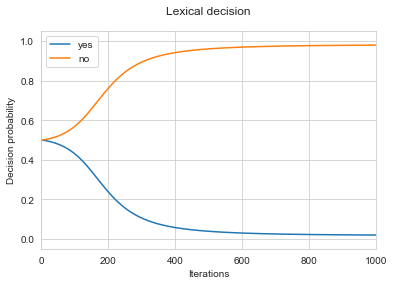

In [33]:
brplt.plot_lexical_decision_evo(model, sim.res["ortho"]["ld"][stimulus], stimulus)

We observe that the probability distribution over words stays very "flat". (We observe, for the first time, a feature of the plotting tools: the blue colored area represents the "sum of all alternative words" (those that do not have an associated curve in the plot.) As before, the probability distribution over lexical membership correclty and rapidly identifies the input as a non-word.

## 8. Exploring the inside of the BRAID model and simu objects

In this last section, we highlight a couple of tools to further explore the insides of the BRAID model and simu objects. We have already showed how some parameters, such as the stimulus and visuo-attentional parameters, could be manipulated. There are other parameters in the model, for instance to control the effect of acuity loss as a function of excentricity, the effect of lateral interference between adjacent letters, or parameters to control the temporal scales of various pieces of the model.

Here are default (internal) parameter values:

<table align="left"

| Parameter name       | Mathematical name | Value |
| -------------------- | ----------------- | ----- |
| Orthographic epsilon | $\epsilon_L$      | 1e-3  |
| Phonological epsilon | $\epsilon_\phi$   | 1e-3  |
| Crowding             | $\theta$          | .675  |
| ScaleI               | $Scale_I$         | 5.8   |
| slopeG               | $Slope_G$         | 1     |
| LeakP                | $Leak_P$          | 1e-4  |
| LeakW                | $Leak_W$          | 1250  |
| LeakLD               | $Leak_{LD}$       | .15   |
>




Here are some parameters usually set during simu configuration:
<table align="left"

| Name                 | Description                                                                               |
| -------------------- | ----------------------------------------------------------------------------------------- |
| max_iter             | number of iterations to simulate                                                          |
| stim                 | input letter string to process                                                            |
| path                 | BRAID project root path                                                                   |
| lexicon_name         | lexicon file (in the 'resources/lexicon' directory)                                       | 
| conf_mat_name        | confusion matrix file (in the 'resources/confusionMatrix' directory)                      | 
| ortho_char_name      | letter list file (in the 'resources/chardicts' directory)                                 | 
| phono_char_name      | phoneme list file (in the 'resources/chardicts' directory)                                | 
| enable_phono         | enable processing to compute phonological output                                          | 
| store_phono          |  during lexicon loading, store the phonological information (if available)                | 
| store_ortho          |   during lexicon loading, store the orthographic information                              | 
| model                | BRAID class instance. `None` implies a new model.                                         | 
| use_pkl              | if True, loads a pre-calculated model (if one corresponding to the parameters is stored)  | 
| save_pkl             | if True, saves the model for future use (loading a model is faster than re-calculating)   | 
| build_prototype      | if True, updates the prototype decrease of entropy with current simulation                |
>


## 8.1. To get current parameter values

In [34]:
print("Current gaze position is:", model.gazePosition)
print("Current attention position is:", model.meanA)
print("Current attention dispersion is:", model.sdA)
print("Current attention quantity is:", model.ortho.Qa)
print("Current stimulus is:", model.stim)

# to get other parameters of the model (crowding, scaleI, slopeG, leakP, leakW)
print("Current scaleI parameter value is:", model.ortho.scaleI)

Current gaze position is: 2.0
Current attention position is: 2.0
Current attention dispersion is: 1.75
Current attention quantity is: 1
Current stimulus is: gckqz
Current scaleI parameter value is: 5.8


## 8.2. To set parameter values

In [35]:
model.gazePosition = 4
print("Current gaze position is:", model.gazePosition)
model.meanA = 4
print("Current attention position is:", model.meanA)
model.sdA = .5
print("Current attention dispersion is:", model.sdA)
model.ortho.Qa = 2
print("Current attention quantity is:", model.ortho.Qa)
model.stim = "helloooo"
print("Current stimulus is:", model.stim)
model.ortho.top_down_influence = False
print("Top-down lexical influence is set to:", model.ortho.top_down_influence)

Current gaze position is: 4
Current attention position is: 4
Current attention dispersion is: 0.5
Current attention quantity is: 2
Current stimulus is: helloooo
Top-down lexical influence is set to: False


The BRAID model structure is organized, with an "ortho" and a "phono" branch. Some attributes are in one or the other, or in the general "model" part. To get the name of all attributes of any portion of the model, use for instance the dir() function. To also see values, use the vars() function. (Careful, lengthy output is expected.) Try for instance `dir(model)` vs `dir(model.ortho)`.

In [36]:
dir(model.ortho)

['N',
 'N_max',
 'Qa',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_repr',
 '_stim',
 'attention_profile',
 'bottom_up_matrix',
 'build_attention_distribution',
 'build_bottom_up_ortho',
 'build_interference_matrix',
 'build_knowledge',
 'build_percept',
 'build_trace',
 'build_whole_knowledge',
 'chars',
 'chars_filename',
 'chars_reduced',
 'complete_repr',
 'confFactor',
 'conf_mat',
 'conf_mat_name',
 'crowding',
 'dist',
 'enabled',
 'eps',
 'exists',
 'get_empty_percept',
 'get_entropy',
 'get_freq',
 'get_index',
 'get_most_probable_word',
 'get_name',
 'get_string_chain',
 'get_word_entry',
 'interference_mat',
 'leakP',
 'learning',
 'mod